# Optimized gauge transformation

## The goal of this notebook is to perform the gauge transformation in an optimized way inside the temporal loop so we can later move it to the GPU

### Set parametres and eviroment variables

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2      
N = 128   
tau_sim = 1     
DTS = 8     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0       

# TODO: Run more events
nevents = 1

In [2]:
import os

# I need to add this line to ask resources from a specific GPU, which is free. Our GPU server has no queing system
os.environ["CUDA_VISIBLE_DEVICES"]="3"

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.lc_gauge as lc
# Number of colors
Nc = su.NC
# Dimension of algebra 
Dg = su.GROUP_ELEMENTS

Using Numba
Using SU(3)
Using double precision


### We define the simulation routine

In [3]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(): 
    # output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Plus gauge link
    uplus_LC = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N, N, Dg)))
    v_LC = su.GROUP_TYPE([[[su.unit() for z in range (N)] for y in range(N)] for xplus in range (maxt//DTS)])

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):            
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Copy gauge links and gauge fields from the memory of the GPU
            if t%DTS == 0:
                u1 = s.u1.copy()
                u0 = s.u0.copy()
                
                ux_act = u1[:,0,:].reshape(N,N,Dg)
                ux_prev = u0[:,0,:].reshape(N,N,Dg)
                
                ae_act = s.aeta1.copy().reshape(N, N, Dg)
                ae_prev = s.aeta0.copy().reshape(N, N, Dg)
                
                # We construct the u_+ links over the x^+ axis in a (y,z) transverse lattice
                uplus_temp = su.GROUP_TYPE(np.zeros((N,N,Dg)))
                
                # for y in range(N):
                #     for z in range(N):
                #         uplus_temp[y, z] = lc.get_plus_links(ux_prev[t//DTS,y], ae_prev[t//DTS,y], z, N)
                
                
                # We construct the gauge operator and transform the field
                for xplus in range(maxt//DTS):
                    for y in range(N):
                        for z  in range(N):
                            
                            if xplus > t: # We construct the gauge operator
                                v_prev = v_LC[xplus, y, z]
                               
                                v_LC[xplus, y, z] = lc.gauge_transformation_operator(ux_act[2*xplus-t//DTS,y], ae_act[2*xplus-t//DTS,y], v_prev, z, N)
                                
                            elif xplus == (t//DTS) and xplus != 0:
                                # This should be here, there is a single value of xplus==t//DTS
                                uplus_temp[y, z] = lc.get_plus_links(ux_prev[t//DTS,y], ae_prev[t//DTS,y], z, N)
                                uplus_LC[xplus-1, y, z] = lc.act_on_links(uplus_temp[y,z], v_LC[xplus, y, z], v_LC[xplus-1, y, z])
                                
            
            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return uplus_LC #ux2 #, uy, aeta

In [4]:
# Supress various horribly long warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
uplus_LC = simulate()

  6%|▋         | 33/512 [00:33<06:40,  1.20it/s] 

Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential

  8%|▊         | 41/512 [00:37<05:20,  1.47it/s]

Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential

 11%|█         | 56/512 [00:40<03:05,  2.46it/s]

Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential

 12%|█▏        | 59/512 [00:43<03:38,  2.07it/s]

Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential

 13%|█▎        | 65/512 [00:44<02:44,  2.72it/s]

Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential

 14%|█▍        | 73/512 [00:45<01:59,  3.67it/s]

Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential

 16%|█▌        | 81/512 [00:46<01:37,  4.43it/s]

Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential

 17%|█▋        | 89/512 [00:47<01:23,  5.09it/s]

Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential

 19%|█▉        | 97/512 [00:48<01:15,  5.47it/s]

Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential

 21%|██        | 105/512 [00:49<01:11,  5.71it/s]

Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential

 22%|██▏       | 112/512 [00:50<00:52,  7.65it/s]

Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential

 22%|██▏       | 115/512 [00:51<01:12,  5.48it/s]

Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential

 24%|██▎       | 121/512 [00:52<01:17,  5.04it/s]

Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential

 25%|██▌       | 129/512 [00:54<01:17,  4.96it/s]

Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential

 27%|██▋       | 136/512 [00:55<02:34,  2.43it/s]

Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential did not reach desired accuracy
Exponential

SystemError: CPUDispatcher(<function get_plus_links at 0x7fc027867950>) returned a result with an error set

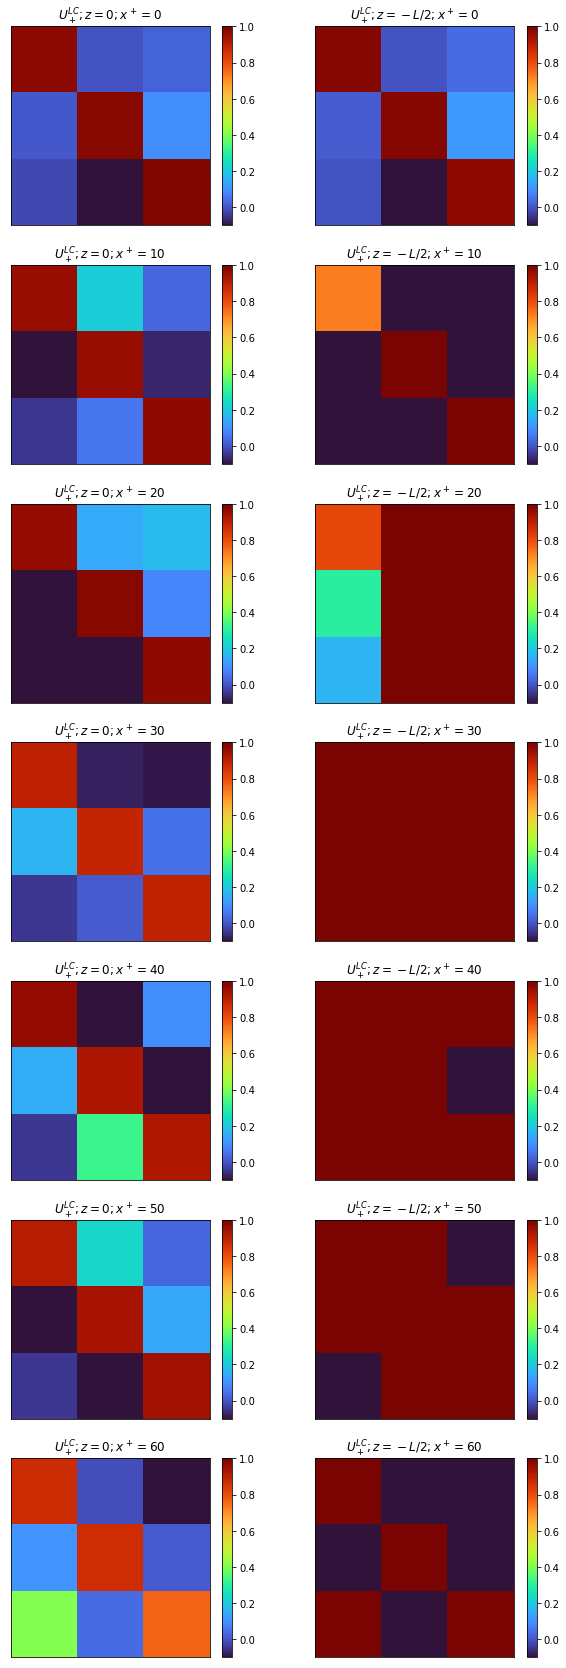

In [6]:
import matplotlib.pyplot as plt 

t_steps = int(tau_sim*N / L)
y = N//2

uplus_LC_plot = uplus_LC.reshape(t_steps-1, N, N, 3, 3)

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(10,30))

for t in range(t_steps//10 + 1): 
    tau = 10*t
    plot1 = axs[t,0].imshow(uplus_LC_plot[tau, y, N//2, :, :].real, cmap='turbo', vmin=-0.1, vmax=1) 
    axs[t,0].set_title(r'$U_+^{LC}; z =0; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,0])
    axs[t,0].axes.get_xaxis().set_visible(False)
    axs[t,0].axes.get_yaxis().set_visible(False)
    
    plot1 = axs[t, 1].imshow(uplus_LC_plot[tau, y, 0, :, :].real, cmap='turbo', vmin=-0.1, vmax=1)
    axs[t,1].set_title(r'$U_+^{LC}; z = -L/2; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,1])
    axs[t,1].axes.get_xaxis().set_visible(False)
    axs[t,1].axes.get_yaxis().set_visible(False)

- - -
Write the outputs to files. First, the numerical Glasma parameters in `glasma_parameters.txt`.

In [10]:
# Save relevant parameters to text file
param_names = ["L [fm]", "N", "a [fm]", "tau_sim [fm/c]", "tau_steps"]
# The last time step in x^+ in skipped, so only N/2-1 time steps
# The lattice discretization in z coincides with the one in y
param_values = [L, N, L/N, tau_sim, int(N/2)-1]

output_file = open("glasma_parameters.txt", "a")
for p in range(len(param_names)):
    output_file.write(param_names[p] + " " + str(param_values[p]) + "\n")
output_file.close()

Second, the transformed gauge link $U_+ (x^+, y, z)$ as a `numpy` array in `uplus_glasma.npy`.

In [11]:
np.save('uplus_glasma.npy', uplus_LC)

In [12]:
# I use this values to test that reading the numpy array in C++ is correct
uplus_LC[10, 12, 10, :]

array([ 0.88283323-0.1551468j , -0.09273007-0.0036718j ,
        0.63236359+0.06059648j, -0.01884896+0.01941451j,
        1.10716269+0.13738078j, -0.29059852+0.17138525j,
        0.52714433-0.14858875j, -0.1834091 +0.1923332j ,
        1.38448757-0.01795878j])